In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import z_project
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load image
image, metadata = load_image("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.tif")


In [4]:
metadata

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [5]:
pixel_ratio = metadata['pixel_ratio']

In [6]:
pixel_ratio

0.18323109343704702

In [8]:
#load ndskl file 
cp, fil, point, specs = load_NDskl("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.NDskl.a.NDskl")
#create skeleton object
skel = Skeleton(cp, fil, point, specs)


/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [9]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

In [10]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


<IPython.core.display.Javascript object>


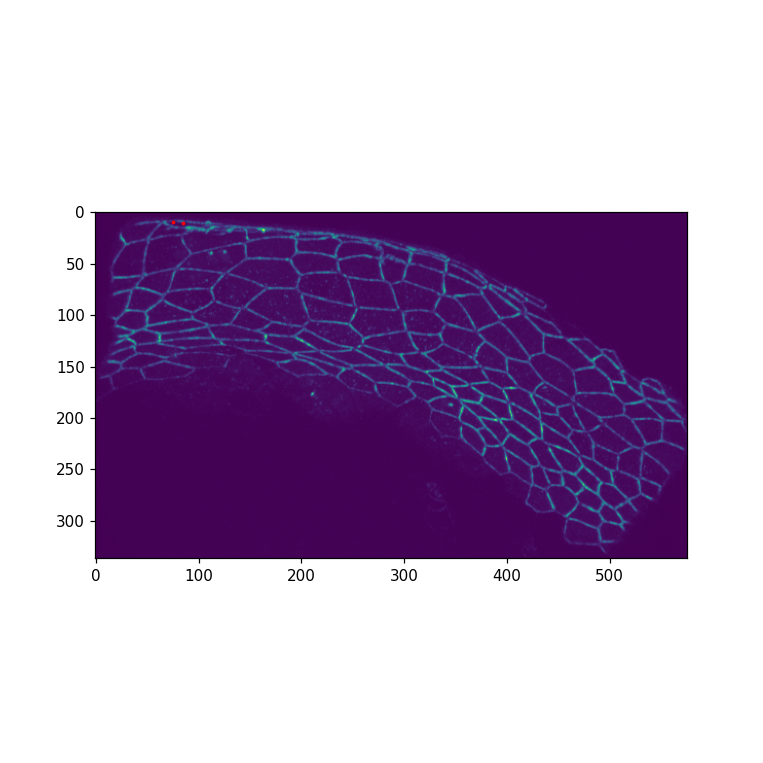

<IPython.core.display.Javascript object>


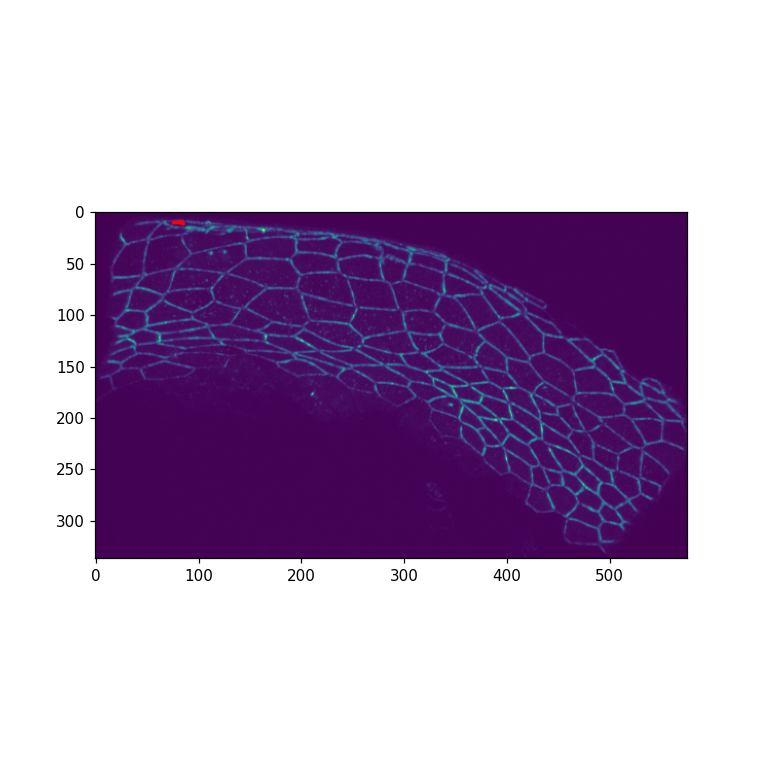

In [25]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp1]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp1]['y'],
            color='red', s=2)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp2]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp2]['y'],
            color='red', s=2)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.point[skel.point['filament']==0]['x'],
            skel.point[skel.point['filament']==0]['y'],
            color='red', s=2)
    
    

In [12]:
skel.specs = specs

<IPython.core.display.Javascript object>


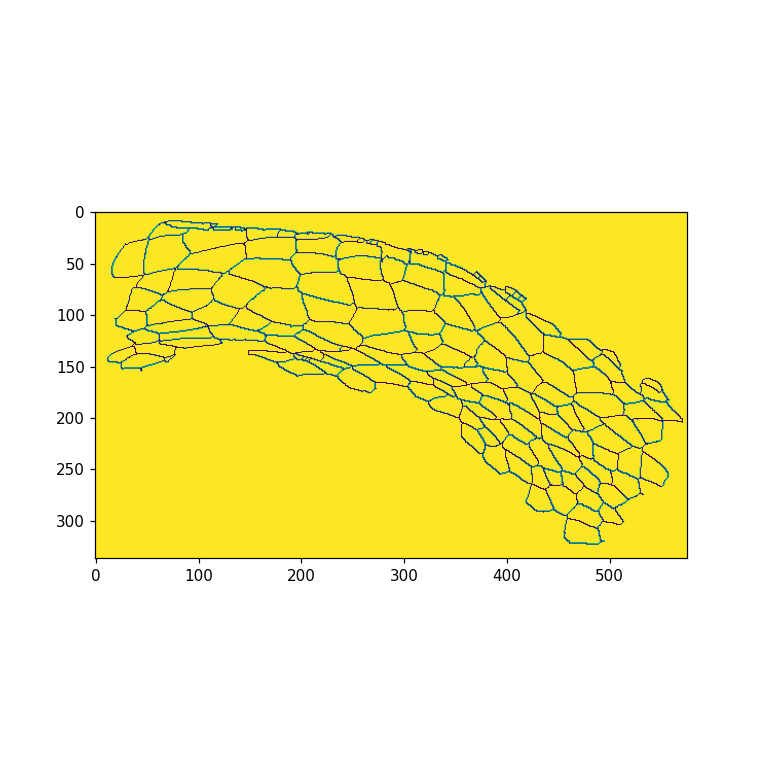

In [26]:
mask = skel.create_binary_image()
plt.figure(figsize=(7,7))
plt.imshow(mask)

<IPython.core.display.Javascript object>


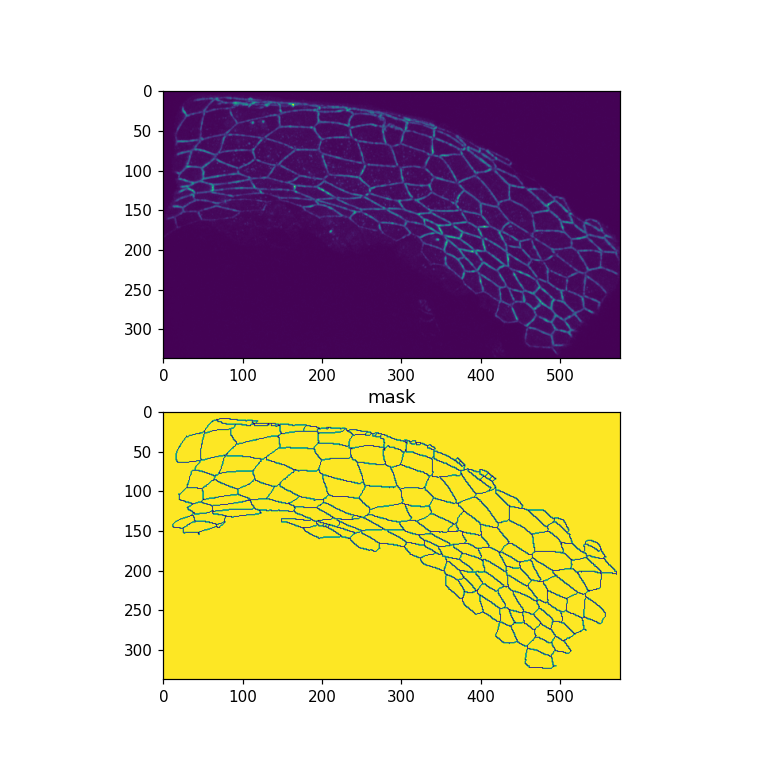

Text(0.5, 1.0, 'mask')

In [27]:
plt.figure(figsize=(7,7))
ax1 = plt.subplot(2,1,1)
ax1.imshow(image,)
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(mask)
ax2.set_title('mask')


<IPython.core.display.Javascript object>


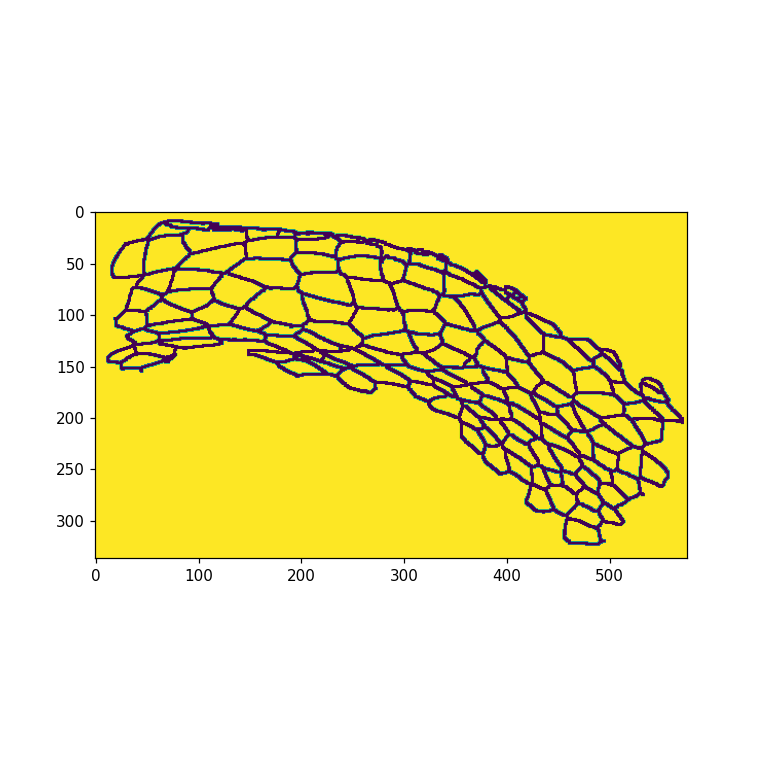

In [28]:
from Dissects.image import dilation
# elargissement
mask_dilation = dilation(mask, 1)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation)


<IPython.core.display.Javascript object>


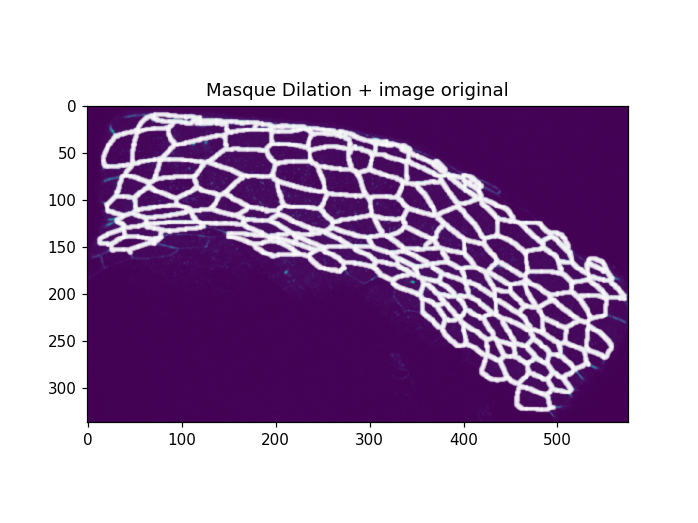

Text(0.5, 1.0, 'Masque Dilation + image original')

In [29]:
fig, ax = plt.subplots()
ax.imshow(image)
y,x = np.where(mask_dilation==0)
ax.scatter(x,y, alpha=0.2, s=2, color='white')
plt.title('Masque Dilation + image original')

<IPython.core.display.Javascript object>


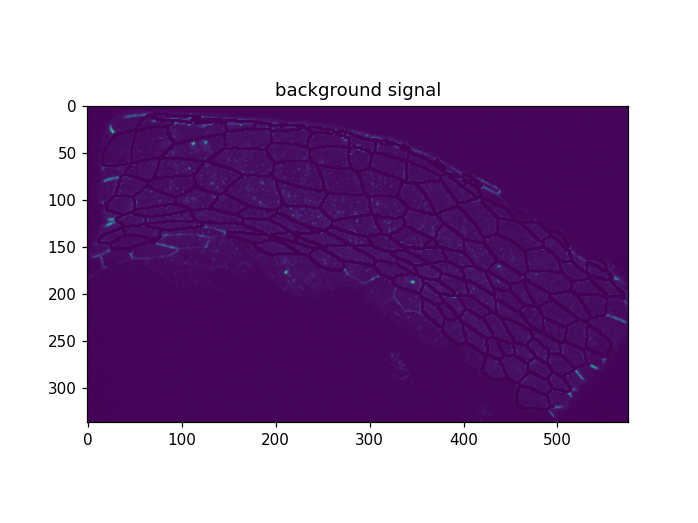

<IPython.core.display.Javascript object>


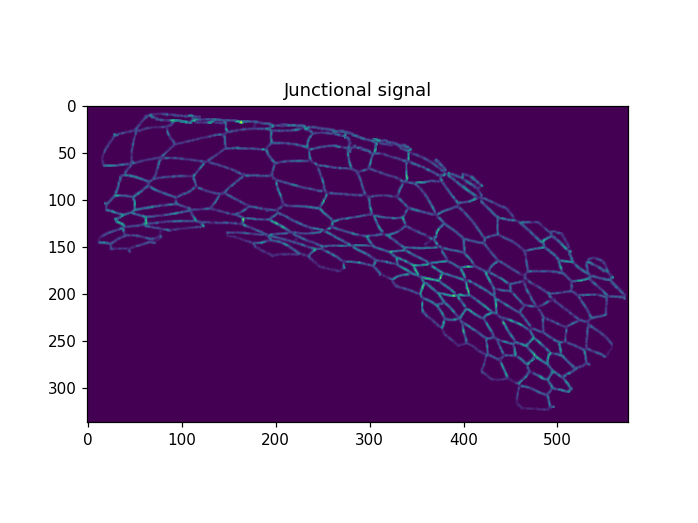

Text(0.5, 1.0, 'Junctional signal')

In [30]:
# Bckground
plt.figure()
plt.imshow(mask_dilation * image)
plt.title('background signal')


#Junction
plt.figure()
plt.imshow((~mask_dilation.astype(bool))*image)
plt.title('Junctional signal')


In [31]:
#from Dissects.analysis import general_analysis
print('mean background =',general_analysis(image, mask_dilation)[0], ',',
      'std =', general_analysis(image, mask_dilation)[1])

print('mean junctional signal=',general_analysis(image, mask_dilation)[2], ',',
      'std =', general_analysis(image, mask_dilation)[3])


mean background = 679.6201338418364 , std = 671.7302549690124
mean junctional signal= 5600.43290185754 , std = 3750.4964749497253


In [19]:
%matplotlib notebook

# Segmentation


In [32]:
seg = segmentation(mask.astype(int), 3)

<IPython.core.display.Javascript object>


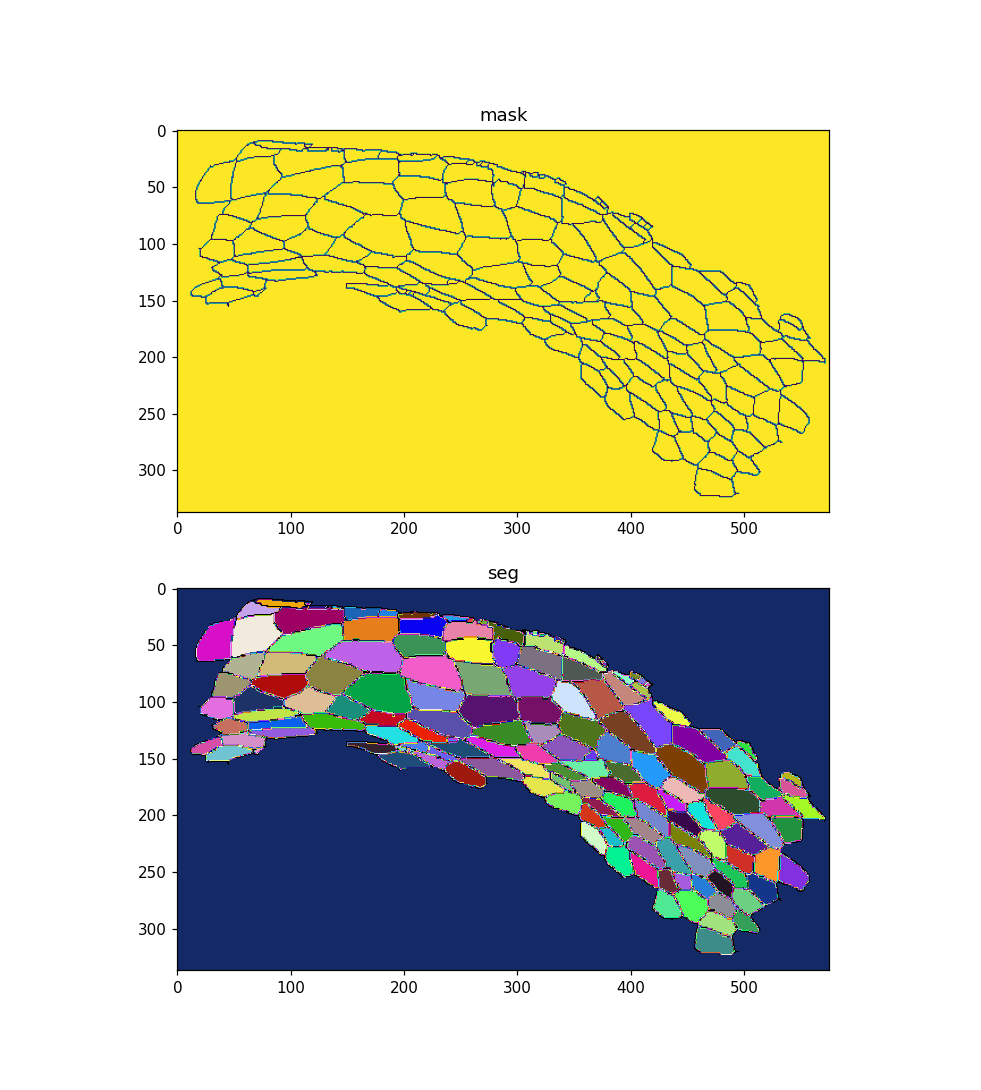

Text(0.5, 1.0, 'seg')

In [33]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(mask)
ax1.set_title('mask')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg, cmap=cmap_rand)
ax2.set_title('seg')

<IPython.core.display.Javascript object>


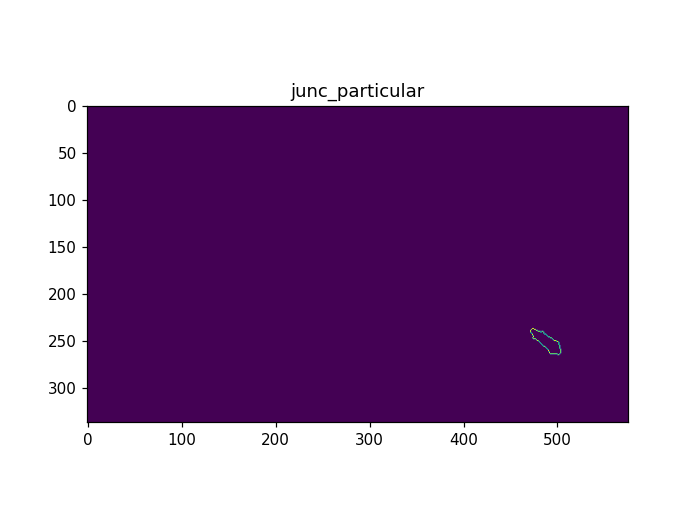

Text(0.5, 1.0, 'junc_particular')

In [34]:
junc_particular = junction_around_cell(mask.astype(int), seg, 151)

plt.figure()
plt.imshow(junc_particular)
plt.title('junc_particular')

In [39]:
from scipy import stats

In [77]:
def cellstats2(image, maskfil, seg, sigmain, scale):
    """
    Create a dataframe.

    Parameters
    ----------
    image : numpy.array
    The normalised image got after applying the normalise_image function.

    maskfil : numpy.array
    The mask of filaments as the wanted enlargment

    seg : numpy.array
    The segmented image got after applying the segmentation function.

    sigmain : string
    The name of the signal analysed.

    scale : integer
    The conversion number -pixel to micrometer- given by import_im
    """

    columns_name = ['CellNbr',
                    'perimeter_um',
                    'areaCell_um2',
                    'meanCell_' + sigmain,
                    'stdCell_' + sigmain,
                    'semCell_' + sigmain,
                    'meanJunc_' + sigmain,
                    'stdJunc_' + sigmain,
                    'semJunc_' + sigmain
                    ]
    nb_cells = len(np.unique(seg)[2:])
    init = np.zeros((nb_cells, len(columns_name)))

    dataframe = pd.DataFrame(data=init,
                             columns=columns_name)

    for ind, i in enumerate(np.unique(seg)[2:]):
        dataframe.loc[ind]['CellNbr'] = i

        cell_junction = junction_around_cell(maskfil, seg, i)
        cell_junction_enlarge_inv = dilation((~cell_junction.astype(bool)).astype(int), width=1)
        cell_junction_enlarge = (~cell_junction_enlarge_inv.astype(bool)).astype(int)
        
        image_cell = image[np.where(seg == i)]
        image_cell_junction = image[np.where(cell_junction_enlarge != 0)]

        dataframe.loc[ind]['perimeter_um'] = len(
            np.where(cell_junction == 1)[0]) / scale
        dataframe.loc[ind]['areaCell_um2'] = len(
            np.where(seg == i)[0]) / scale**2

        # Cytoplasm signal
        dataframe.loc[ind]['meanCell_' + sigmain] = np.mean(image_cell)
        dataframe.loc[ind]['stdCell_' + sigmain] = np.std(image_cell)
        dataframe.loc[ind]['semCell_' + sigmain] = stats.sem(image_cell)

        # Junction signal
        dataframe.loc[ind]['meanJunc_' +
                           sigmain] = np.mean(image_cell_junction)
        dataframe.loc[ind]['stdJunc_' + sigmain] = np.std(image_cell_junction)
        dataframe.loc[ind]['semJunc_' +
                           sigmain] = stats.sem(image_cell_junction)

    return dataframe

In [78]:
df_acat2 = cellstats2(image, mask, seg, sigmain='a-cat', scale=1/pixel_ratio)

In [79]:
df_acat2


,CellNbr,perimeter_um,areaCell_um2,meanCell_a-cat,stdCell_a-cat,semCell_a-cat,meanJunc_a-cat,stdJunc_a-cat,semJunc_a-cat
0,2.0,16.857261,6.714727,4031.760000,3355.712737,237.880169,7165.116129,4402.412673,250.444507
1,3.0,15.208181,9.400617,2223.839286,1972.670695,118.100705,4935.668874,3419.218266,197.080464
2,4.0,2.198773,0.268589,5912.125000,2149.063426,812.269625,8115.000000,4201.961773,626.391478
3,5.0,6.413088,1.040783,4453.677419,2312.127206,422.134742,6664.771930,4149.585752,390.360191
4,6.0,27.667895,33.707928,1960.424303,2316.228171,73.135944,6103.937381,4188.436616,182.624515
...,...,...,...,...,...,...,...,...,...
150,159.0,15.208181,18.633367,1589.596396,1569.052990,66.662674,6273.822086,4406.117504,244.407424
151,160.0,12.093252,11.347888,2400.529586,2677.213278,145.837100,7830.208955,4412.621545,270.048053
152,161.0,11.177097,8.561277,2490.650980,2486.808934,156.036270,7393.537190,3866.206012,249.044222
153,162.0,14.658487,14.235221,2161.320755,2668.793440,129.761177,6351.563694,3839.969293,217.047897


In [45]:
cell_junction = junction_around_cell(mask, seg, 2)

In [57]:
a=(~mask.astype(bool)).astype(int)

In [74]:
cell_junction_enlarge_inv = dilation((~cell_junction.astype(bool)).astype(int), width=1)

In [75]:
cell_junction_enlarge = (~cell_junction_enlarge_inv.astype(bool)).astype(int)

In [66]:
a=dilation((~cell_junction.astype(bool)).astype(int), width=1)

<IPython.core.display.Javascript object>


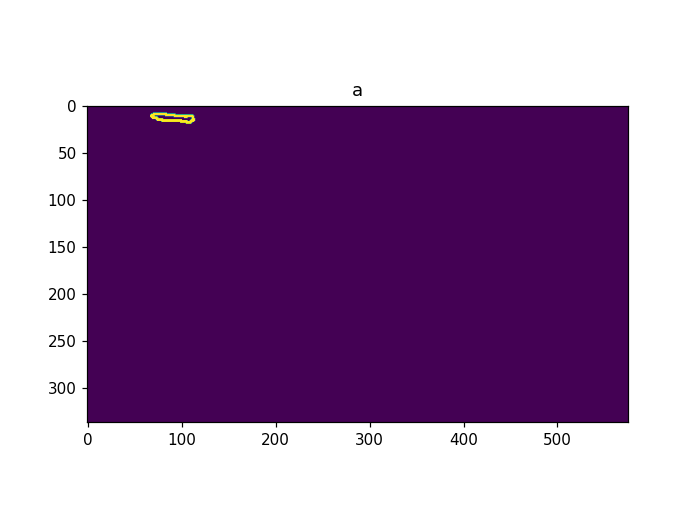

Text(0.5, 1.0, 'a')

In [76]:
plt.figure()
plt.imshow(cell_junction_enlarge)
plt.title('a')

In [41]:
df_acat2 = cellstats2(image, mask, seg, sigmain='a-cat', scale=1/pixel_ratio)

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
df_acat2

,CellNbr,perimeter_um,areaCell_um2,meanCell_a-cat,stdCell_a-cat,semCell_a-cat,meanJunc_a-cat,stdJunc_a-cat,semJunc_a-cat
0,2.0,16.857261,6.714727,4031.760000,3355.712737,237.880169,NaN,NaN,NaN
1,3.0,15.208181,9.400617,2223.839286,1972.670695,118.100705,NaN,NaN,NaN
2,4.0,2.198773,0.268589,5912.125000,2149.063426,812.269625,NaN,NaN,NaN
3,5.0,6.413088,1.040783,4453.677419,2312.127206,422.134742,NaN,NaN,NaN
4,6.0,27.667895,33.707928,1960.424303,2316.228171,73.135944,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
150,159.0,15.208181,18.633367,1589.596396,1569.052990,66.662674,NaN,NaN,NaN
151,160.0,12.093252,11.347888,2400.529586,2677.213278,145.837100,NaN,NaN,NaN
152,161.0,11.177097,8.561277,2490.650980,2486.808934,156.036270,NaN,NaN,NaN
153,162.0,14.658487,14.235221,2161.320755,2668.793440,129.761177,NaN,NaN,NaN


In [35]:

df_acat=cellstats(image, mask, seg, sigmain='a-cat', scale=1/pixel_ratio)

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
df_acat

,CellNbr,perimeter_um,areaCell_um2,meanCell_a-cat,stdCell_a-cat,semCell_a-cat,meanJunc_a-cat,stdJunc_a-cat,semJunc_a-cat
0,2.0,16.857261,6.714727,4031.760000,3355.712737,237.880169,NaN,NaN,NaN
1,3.0,15.208181,9.400617,2223.839286,1972.670695,118.100705,NaN,NaN,NaN
2,4.0,2.198773,0.268589,5912.125000,2149.063426,812.269625,NaN,NaN,NaN
3,5.0,6.413088,1.040783,4453.677419,2312.127206,422.134742,NaN,NaN,NaN
4,6.0,27.667895,33.707928,1960.424303,2316.228171,73.135944,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
150,159.0,15.208181,18.633367,1589.596396,1569.052990,66.662674,NaN,NaN,NaN
151,160.0,12.093252,11.347888,2400.529586,2677.213278,145.837100,NaN,NaN,NaN
152,161.0,11.177097,8.561277,2490.650980,2486.808934,156.036270,NaN,NaN,NaN
153,162.0,14.658487,14.235221,2161.320755,2668.793440,129.761177,NaN,NaN,NaN


# Vertices


In [22]:
#Récupération des indices des cellules ayant une jonction en commun
m = []
n = []

for k in JuncCell.keys():
    m.append(k[0])
    n.append(k[1])
    
    
#Création d'un DataFrame
init = np.zeros((len(JuncCell),6))
df1 = pd.DataFrame(data=init, columns=['cellule a','cellule b','longueur','meanJunc','stdJunc','semJunc'])    
    
for ind,i in enumerate (JuncCell.keys()):
    
    JuncCell_conv = convolve(JuncCell[i],Tophat2DKernel(KernelSize))
    JuncCell_conv[np.where(JuncCell_conv != 0)] = 1
    
    df1['cellule a'][ind] = m[ind]
    df1['cellule b'][ind] = n[ind]
    df1['longueur'][ind] = len(np.where(JuncCell[i] == 1)[0])
    df1['meanJunc'][ind] = np.mean(im[np.where(JuncCell_conv != 0)])
    df1['stdJunc'][ind] = np.std(im[np.where(JuncCell_conv != 0)])
    df1['semJunc'][ind] = sc.stats.sem(im[np.where(JuncCell_conv != 0)])


NameError: name 'JuncCell' is not defined

# Ellipses

In [24]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import warnings
%matplotlib inline
# fitting procedure
fit = fitting.SimplexLSQFitter() 
#fit = fitting.LevMarLSQFitter()

In [25]:
from multiprocessing import Pool
from itertools import repeat
import time



def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

def cellgeoi(inputs):
    ind,i,seg = inputs
    print(i)

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1.,
                           x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    
    ei1 = models.Ellipse2D(amplitude=1.,
                           x_0=g1.x_mean, 
                           y_0=g1.y_mean, 
                           a=g1.x_stddev, 
                           b=g1.y_stddev,
                           theta=g1.theta, 
                           fixed={'x_0': True, 'y_0':True, 'theta':True})
    
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c
    
    return e1


In [69]:
start = time.time()
y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),5))
Dataframe_geo_para = pd.DataFrame(data=init,columns=['x_0','y_0','a','b','theta'])

all_inputs = zip(range(len(np.unique(seg)[2:])),np.unique(seg)[2:],repeat(seg))

pool = Pool(4)
CellGeo= pool.map_async(cellgeoi, all_inputs)
pool.close()
pool.join()
e1l = CellGeo.get()

for ind,i in enumerate(np.unique(seg)[2:]):
    print(i)
    Dataframe_geo_para['x_0'][ind] = e1l[ind].x_0.value
    Dataframe_geo_para['y_0'][ind] = e1l[ind].y_0.value
    Dataframe_geo_para['a'][ind] = e1l[ind].a.value
    Dataframe_geo_para['b'][ind] = e1l[ind].b.value
    Dataframe_geo_para['theta'][ind] = e1l[ind].theta.value

Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']
Dataframe_geo_para['a um'] = Dataframe_geo_para['a'] * pixel_ratio
Dataframe_geo_para['b um'] = Dataframe_geo_para['b'] * pixel_ratio

#Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
#Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']

end=time.time()

print('Cell Geo 4 cores ran in ',(end-start)/60.,' min')

2
13
25
35
36
14
26
3
37
27
4
15
28
38
16
5
29
39
17
40
30
18
19
41
31
42
20
32
43
21
33
44
22
34
46
56
57
66
47
58
67
48
59
68
60
6
69
49
61
7
71
50
62
72
51
63
8
73
64
9
74
52
65
75
11
53
77
76
12
54
78
87
98
55
79
88
80
109
99
89
81
110
90
82
100
111
91
83
101
112
92
84
102
113
93
85
94
114
103
96
86
115
104
97
116
119
105
129
117
120
106
130
118
108
121
131
139
149
122
132
140
150
123
133
141
124
151
134
142
125
135
152
126
143
153
127
136
144
128
137
154
145
159
138
146
155
160
147
156
161
148
157
162
158
163
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
96
97
98
99
100
101
102
103
104
105
106
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


In [52]:
e1l

[<Ellipse2D(amplitude=1., x_0=90.82130799, y_0=13.10689449, a=22.98224028, b=2.62817447, theta=0.08152298)>,
 <Ellipse2D(amplitude=1., x_0=69.70326259, y_0=18.98775834, a=18.71737108, b=4.4836741, theta=-0.04745638)>,
 <Ellipse2D(amplitude=1., x_0=115.00142702, y_0=13.47093948, a=1.50603261, b=0.3244335, theta=-0.00113281)>,
 <Ellipse2D(amplitude=1., x_0=123.25137702, y_0=16.49724637, a=5.53990068, b=0.29213224, theta=-0.00139525)>,
 <Ellipse2D(amplitude=1., x_0=113.84720602, y_0=26.57065077, a=32.68521211, b=9.24131986, theta=-0.07947551)>,
 <Ellipse2D(amplitude=1., x_0=139.73774364, y_0=16.69955208, a=2.7656326, b=0.61483195, theta=-0.01620985)>,
 <Ellipse2D(amplitude=1., x_0=161.42172756, y_0=21.44071278, a=17.38239082, b=4.24556189, theta=-0.04526081)>,
 <Ellipse2D(amplitude=1., x_0=185.67815822, y_0=21.89255461, a=8.71146387, b=2.99030722, theta=0.02120187)>]

In [70]:
Dataframe_geo_para

,x_0,y_0,a,b,theta,e,an,a um,b um
0,90.821308,13.106894,22.982240,2.628174,0.081523,0.993440,8.744564,4.211061,0.481563
1,69.703263,18.987758,18.717371,4.483674,-0.047456,0.970885,4.174561,3.429604,0.821549
2,115.001427,13.470939,1.506033,0.324434,-0.001133,0.976521,4.642038,0.275952,0.059446
3,123.251377,16.497246,5.539901,0.292132,-0.001395,0.998609,18.963675,1.015082,0.053528
4,113.847206,26.570651,32.685212,9.241320,-0.079476,0.959197,3.536855,5.988947,1.693297
...,...,...,...,...,...,...,...,...,...
150,453.998752,279.104704,16.110637,11.056685,0.811235,0.727321,1.457095,2.951970,2.025928
151,480.658957,279.337690,13.595652,7.732807,0.548860,0.822496,1.758178,2.491146,1.416891
152,500.358940,294.404387,11.829620,6.584802,0.648575,0.830756,1.796503,2.167554,1.206541
153,477.205065,295.479447,16.642180,8.237807,0.359056,0.868895,2.020220,3.049365,1.509422


In [71]:
from multiprocessing import Pool
import time

In [84]:
Dataframe_geo_para.to_csv('Dataframe_geo_para.csv',index=False)
#Dataframe_geo_para = pd.read_csv('/home/tmerle/Dataframe_geo_para.csv')

In [72]:
np.mean(Dataframe_geo_para['a um'])

3.1554906861869028

In [73]:
from matplotlib.colors import LogNorm,PowerNorm

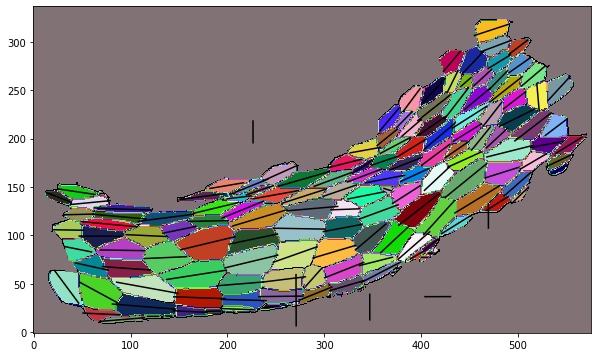

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    
    plt.plot([startx, endx], [starty, endy], color='black')

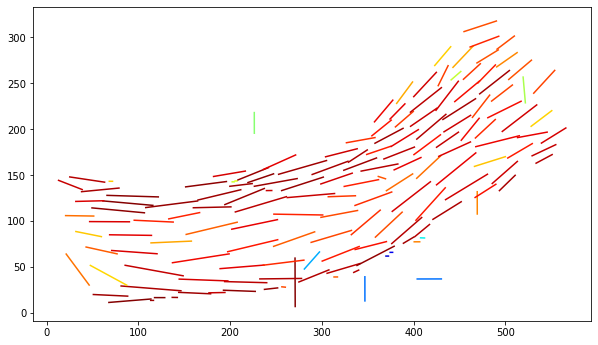

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])

    colori = plt.cm.jet(Dataframe_geo_para['e'][i]) # r is 0 to 1 inclusive
        
    plt.plot([startx, endx], [starty, endy], color=colori)
   
#plt.colorbar(Dataframe_geo_para_bis['e'])

In [77]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [78]:
'''Fonction pour la jolie color bar'''

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [82]:
%matplotlib notebook

<IPython.core.display.Javascript object>


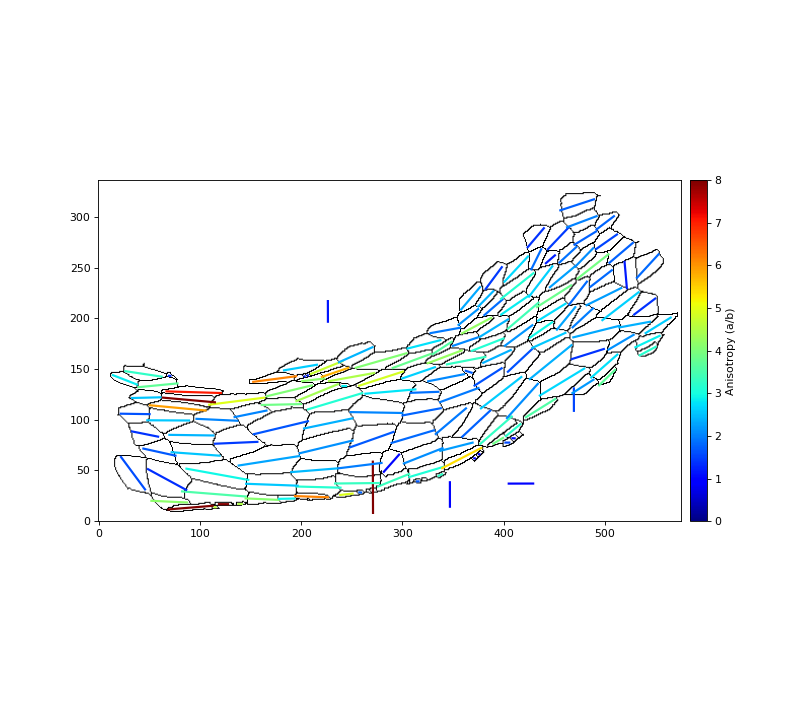

In [83]:
fig = plt.figure(figsize=(10,9))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap='viridis')
plt.imshow(mask,origin='lower',cmap='gist_gray')
xs = []
ys = []
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    xs.append([startx,endx])
    ys.append([starty,endy])
c = Dataframe_geo_para['an']
lc = multiline(xs, ys, c, cmap='jet', lw=2, clim = (0,8))
add_colorbar(lc, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')